In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')
test_path = "/content/gdrive/MyDrive/300WLPA_2dLFPW.zip"
train_path = "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Mounted at /content/gdrive


In [23]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=90691fc365ed54db92e7d92b22546c6bfd6a109b338167e05fb531c22b8b14eb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [24]:
!unzip "/content/gdrive/MyDrive/300WLPA_2dLFPW.zip"

Archive:  /content/gdrive/MyDrive/300WLPA_2dLFPW.zip
warning [/content/gdrive/MyDrive/300WLPA_2dLFPW.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/MyDrive/300WLPA_2dLFPW.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace 300WLPA_2d/images/LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.418_0.122_-0.005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
!unzip "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Archive:  /content/gdrive/MyDrive/train_data/dataset_1000.zip
 extracting: 000000.png              
 extracting: 000000_seg.png          
 extracting: 000000_ldmks.txt        
 extracting: 000001.png              
 extracting: 000001_seg.png          
 extracting: 000001_ldmks.txt        
 extracting: 000002.png              
 extracting: 000002_seg.png          
 extracting: 000002_ldmks.txt        
 extracting: 000003.png              
 extracting: 000003_seg.png          
 extracting: 000003_ldmks.txt        
 extracting: 000004.png              
 extracting: 000004_seg.png          
 extracting: 000004_ldmks.txt        
 extracting: 000005.png              
 extracting: 000005_seg.png          
 extracting: 000005_ldmks.txt        
 extracting: 000006.png              
 extracting: 000006_seg.png          
 extracting: 000006_ldmks.txt        
 extracting: 000007.png              
 extracting: 000007_seg.png          
 extracting: 000007_ldmks.txt        
 extracting: 000008.png   

In [26]:
#install weights and biases for data logging
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 27.3 MB/s 
     |████████████████████████████████| 182 kB 61.9 MB/s 
     |████████████████████████████████| 168 kB 63.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 53.4 MB/s 
     |████████████████████████████████| 166 kB 63.6 MB/s 
     |████████████████████████████████| 162 kB 59.1 MB/s 
     |████████████████████████████████| 162 kB 55.1 MB/s 
     |████████████████████████████████| 158 kB 55.6 MB/s 
     |████████████████████████████████| 157 kB 69.2 MB/s 
     |████████████████████████████████| 157 kB 72.7 MB/s 
     |████████████████████████████████| 157 kB 71.1 MB/s 
     |████████████████████████████████| 157 kB 69.7 MB/s 
     |████████████████████████████████| 157 kB 70.6 MB/s 
     |████████████████████████████████| 157 kB 68.9 MB/s 
     |███████████████████████████

In [27]:
#time all processes to measure network efficiency
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 27.9 MB/s 
time: 563 µs (started: 2022-11-21 17:54:04 +00:00)


**Imports**

In [28]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations
import wandb

time: 1.4 s (started: 2022-11-21 17:54:35 +00:00)


**Config**

In [34]:
#paths
TEST_ROOT_PATH = '/content/300WLPA_2d'
TRAIN_ROOT_PATH = '/content'
OUTPUT_PATH = 'outputs'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

time: 1.7 ms (started: 2022-11-21 17:55:27 +00:00)


**Utility**

In [39]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    #plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    #plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()
  

time: 8.63 ms (started: 2022-11-21 18:06:28 +00:00)


**Dataset Class**

In [32]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = self.normalize(image)
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      names = []
      for i in range(0,139):
        names.append(str(i))
      dataframe = pd.read_csv(filepath_or_buffer = path + "/keypoints/300WLPA_LFPW.txt", sep=" ", names=names, header=None)
      self.data = dataframe
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_300WLPA_item(self, name):
      pathname = self.path + "/images/" + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      keypoints = self.data.loc[name].to_numpy()
      keypoints = keypoints[0:136] #last 3 values are not point coords (2 of them are negative)
      # reshape the keypoints
      half_point = len(keypoints)/2
      half_point = int(half_point)
      fixed_keypoints = np.zeros((68, 2))
      for i in range(half_point):
        fixed_keypoints[i][0] = keypoints[i]
        fixed_keypoints[i][1] = keypoints[half_point+i]
      # rescale keypoints according to image resize
      fixed_keypoints = fixed_keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(fixed_keypoints,dtype=torch.float)

    def get_300WLPA_Data(self):
      #get image names and keypoint data all in a single dataframe
      #randomly get 1000 image names from column 0 of the dataframe.
      image_names = self.data.index.to_numpy()
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(image_names)
      image_names = image_names[0:1000]

      return image_names

time: 9.42 ms (started: 2022-11-21 17:54:56 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


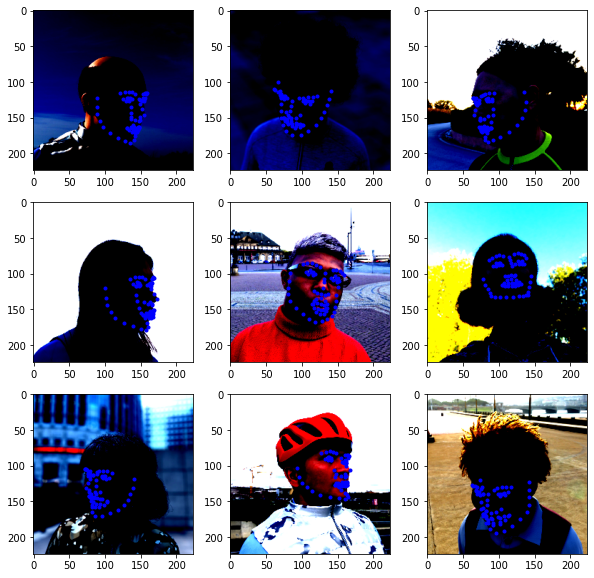

time: 1.92 s (started: 2022-11-21 17:55:32 +00:00)


In [35]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(valid_data)


**Model Class**

In [36]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

time: 8.29 ms (started: 2022-11-21 17:55:41 +00:00)


**Training**

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexmountain. Use `wandb login --relogin` to force relogin


Epoch 1 of 10
Training


29it [00:46,  1.60s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


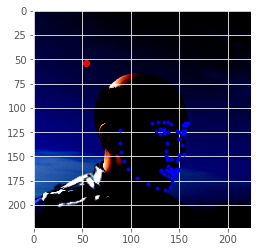

4it [00:05,  1.25s/it]


Train Loss: 97.9400
Val Loss: 67.5112
NME: 2.9348
Epoch 2 of 10
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


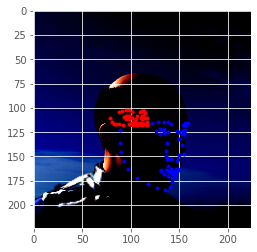

4it [00:03,  1.04it/s]


Train Loss: 38.7595
Val Loss: 23.1188
NME: 1.2289
Epoch 3 of 10
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


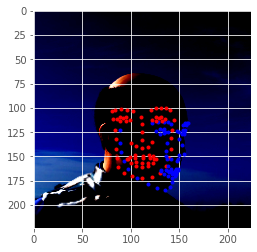

4it [00:03,  1.04it/s]


Train Loss: 14.7287
Val Loss: 13.2915
NME: 0.7117
Epoch 4 of 10
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


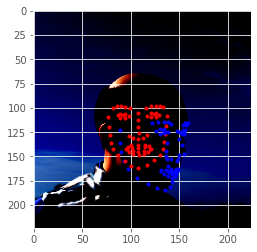

4it [00:03,  1.02it/s]


Train Loss: 13.8227
Val Loss: 13.6848
NME: 0.7566
Epoch 5 of 10
Training


29it [00:38,  1.32s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


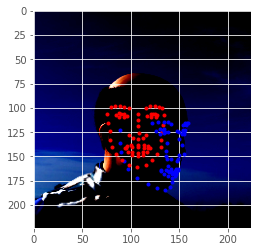

4it [00:03,  1.04it/s]


Train Loss: 13.4465
Val Loss: 13.8886
NME: 0.7568
Epoch 6 of 10
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


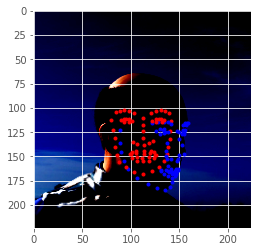

4it [00:03,  1.04it/s]


Train Loss: 13.6105
Val Loss: 13.3566
NME: 0.7996
Epoch 7 of 10
Training


29it [00:39,  1.37s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


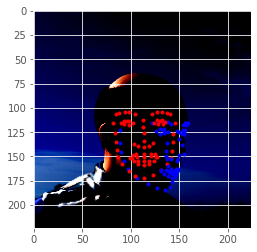

4it [00:03,  1.02it/s]


Train Loss: 13.3396
Val Loss: 13.1319
NME: 0.7310
Epoch 8 of 10
Training


29it [00:41,  1.42s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


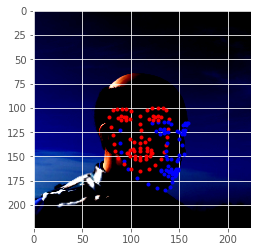

4it [00:04,  1.03s/it]


Train Loss: 13.5989
Val Loss: 13.1786
NME: 0.7226
Epoch 9 of 10
Training


29it [00:37,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


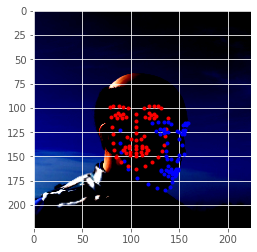

4it [00:03,  1.03it/s]


Train Loss: 13.5275
Val Loss: 13.2696
NME: 0.7194
Epoch 10 of 10
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


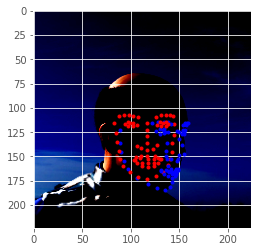

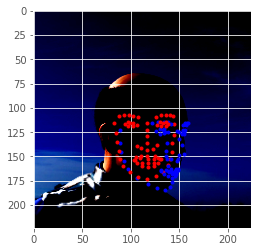

 33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


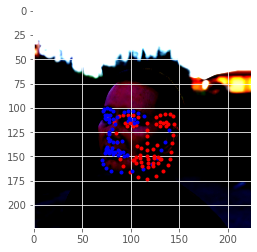

 67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


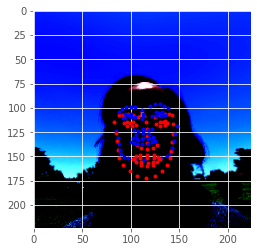

100%|██████████| 3/3 [00:04<00:00,  1.32s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


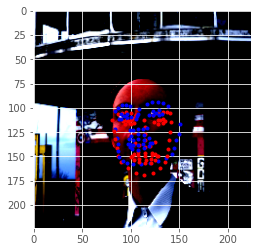

4it [00:04,  1.25s/it]


Train Loss: 13.0660
Val Loss: 13.4808
NME: 0.7254


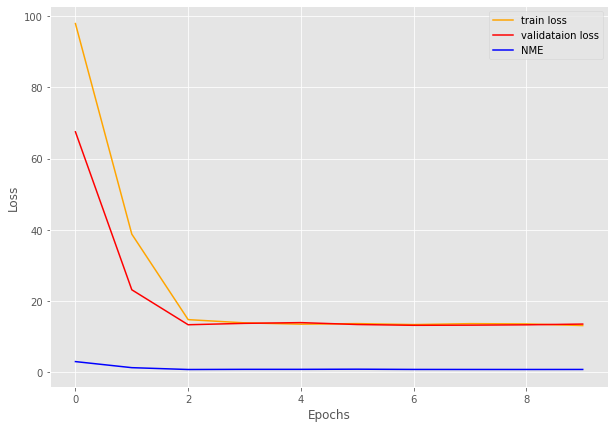

DONE TRAINING
time: 7min 36s (started: 2022-11-21 17:55:45 +00:00)


In [37]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark 
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]
    
    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test both MSELoss and SmoothL1Loss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="resnet50_domain_gap")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'sample_data/resnet50_1000.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"{OUTPUT_PATH}/loss.png")
plt.show()

print('DONE TRAINING')


**Testing Phase**

68.0


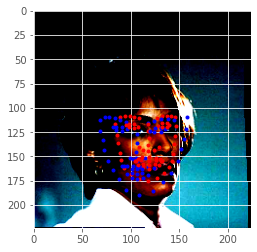

0.24572379079561052
68.0
0.289394832251389
68.0
0.31714554597414985
68.0
0.32489425452883086
68.0
0.35414913235028217
68.0
0.3343693986321126
68.0
0.3305172381607035
68.0
0.3495495779351884
68.0
0.7657698512606153
68.0
0.7440325425075209
68.0
0.6798881501661934
68.0
0.6724266803674586
68.0
0.8665241678296123
68.0
0.7608467191555878
68.0
0.7893777203974647
68.0
0.7138826992376438
68.0
0.8298194968937996
68.0
0.8747159950433822
68.0
0.8026316111041313
68.0
1.1067197245629938
68.0


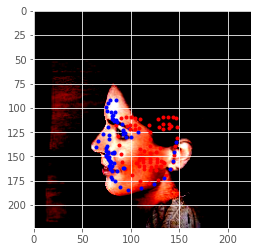

1.0853453792562417
68.0
0.8715056187878395
68.0
0.8559798604503505
68.0
0.9450924138572497
68.0
0.8829675804557661
68.0
1.0940274477575316
68.0
1.0173863402140313
68.0
0.8496876794832
68.0
1.4959493565957291
68.0
1.3389520095897216
68.0
1.1373081782740635
68.0
1.034606739882921
68.0
0.9028602396271354
68.0
0.34363784427268557
68.0
0.37849568709073794
68.0
0.3768416303978491
68.0
0.38526675048212045
68.0
0.4050249646491802
68.0
0.4154215634851311
68.0
0.39613812608406956
68.0


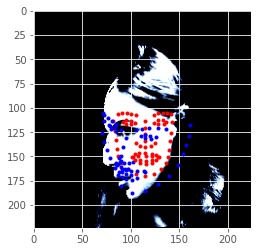

0.4079516595518895
68.0
0.42172465109227797
68.0
0.4590939964469779
68.0
0.4574199192894582
68.0
0.463790585113053
68.0
0.4745027326880332
68.0
0.49780013072652385
68.0
0.4983826533571543
68.0
0.5064607890429308
68.0
0.5464810648162349
68.0
0.5540948580383998
68.0
0.5566960209240094
68.0
0.5868807182724409
68.0
0.582862063137778
68.0
0.5861320718948385
68.0
0.703490656541165
68.0
0.6343348323923488
68.0
0.6214762773086906
68.0
0.21916156658886485
68.0
0.23014271867469274
68.0


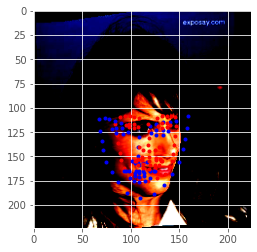

0.2527368679549608
68.0
0.2877117219225421
68.0
0.3606050724325503
68.0
0.35163441263633954
68.0
0.25436566260319216
68.0
0.26255432928727845
68.0
0.31160225991802903
68.0
0.3150944877252477
68.0
0.32515187279447616
68.0
0.3645459864627933
68.0
0.7448242614913357
68.0
0.7066566101084892
68.0
0.7213956581497883
68.0
0.6814504780323171
68.0
0.6540276885361167
68.0
0.9130208768883458
68.0
0.8218807447886166
68.0
0.7665138687026373
68.0
0.7740047541920162
68.0
0.7091352062374056
68.0


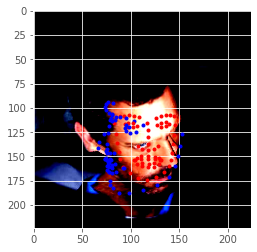

1.0503261576135396
68.0
0.9065623703600848
68.0
0.9042856423064791
68.0
0.8283712871552619
68.0
0.7630778229327043
68.0
0.7761358203143542
68.0
1.1989681404978718
68.0
1.0229462901096464
68.0
0.9588886111776674
68.0
0.9139735820891841
68.0
0.7954015241338075
68.0
0.7435247229896169
68.0
1.2407204294332175
68.0
1.1849046677782877
68.0
0.9981256252389774
68.0
0.873481880099314
68.0
0.8075200646548789
68.0
1.459934780196374
68.0
1.2440999882673454
68.0
1.1517337457289045
68.0


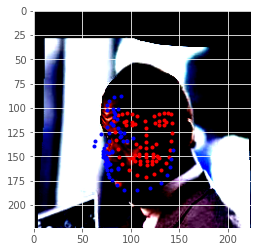

0.9658820625789197
68.0
0.8493356725712388
68.0
1.475003159058679
68.0
1.1730123359612377
68.0
1.0659082078487376
68.0
0.990914022874244
68.0
0.939084336735914
68.0
0.28333966306761976
68.0
0.3006442018963365
68.0
0.3187729843758584
68.0
0.41697697459749866
68.0
0.4484960150229183
68.0
0.39331480219992027
68.0
0.3445237694630762
68.0
0.36366684038538044
68.0
0.42195339768404383
68.0
0.3941348982569462
68.0
0.41300229141637795
68.0
0.3785773650922897
68.0
0.3826243768476759
68.0


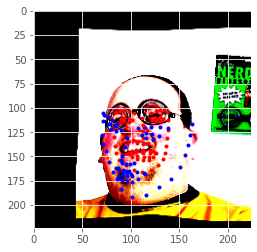

0.4105933186085001
68.0
0.42234316981968717
68.0
0.42295155342082463
68.0
0.4366150690816995
68.0
0.4265008396597494
68.0
0.41752660801075536
68.0
0.4488657338039937
68.0
0.4430197896151205
68.0
0.4563137516334392
68.0
0.46400826923744726
68.0
0.4671575444634033
68.0
0.47568041172095654
68.0
0.4849377953044197
68.0
0.495152646044818
68.0
0.49939279442769685
68.0
0.5380396836226812
68.0
0.5309655372725665
68.0
0.5391186632623671
68.0
0.5376797289486435
68.0
0.5374275184820704
68.0


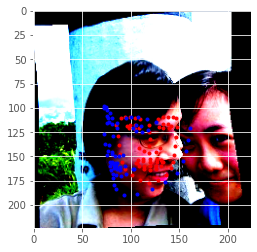

0.6456857344085871
68.0
0.6053058828424526
68.0
0.6078193996705064
68.0
0.5801580841546387
68.0
0.5770948054033553
68.0
0.5726474358873495
68.0
0.674023310025207
68.0
0.6361379898154694
68.0
0.6429191763323022
68.0
0.6449706508495449
68.0
0.6186736092133386
68.0
0.2969172205137344
68.0
0.3158535554525159
68.0
0.37212860990393737
68.0
0.358251053825023
68.0
0.43049724886955093
68.0
0.4592952297776808
68.0
0.3495029943828692
68.0
0.3718683987022085
68.0
0.3943860612810807
68.0


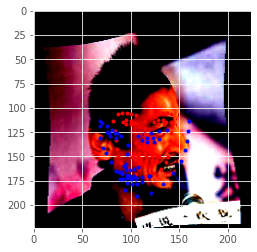

0.4171816063935421
68.0
0.4459565870269776
68.0
0.9794892581788242
68.0
0.9028089525624585
68.0
0.8370199428541187
68.0
0.825333345028394
68.0
1.075935585083037
68.0
0.9757832092172974
68.0
0.929950423289584
68.0
0.8609427767243751
68.0
1.3652228237820323
68.0
1.1766073950439604
68.0
1.0768359790838256
68.0
1.011757983334496
68.0
0.983168225055575
68.0
1.7878664308712475
68.0
1.3551657182030656
68.0
1.2505170246296982
68.0
1.0827283392478046
68.0
0.9886526638943582
68.0


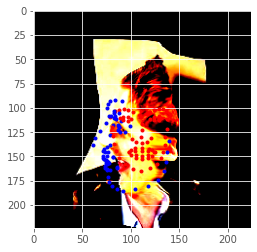

1.514171576107179
68.0
1.3321713679942917
68.0
1.1431267512608616
68.0
1.0469947786351723
68.0
0.9024724627084869
68.0
1.5982202715005658
68.0
1.4801756909741595
68.0
1.2104968807119374
68.0
1.0177913880856566
68.0
0.938286034485156
68.0
0.4094171693550656
68.0
0.43794141026431854
68.0
0.4456940179413341
68.0
0.4501735268199894
68.0
0.4322203746367747
68.0
0.4431640642316105
68.0
0.45933576930128256
68.0
0.4815654107822697
68.0
0.47703949969242876
68.0
0.48597293805307357
68.0


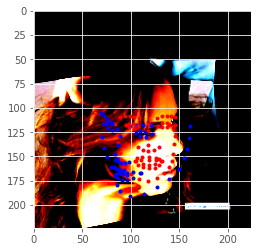

0.5010721044383859
68.0
0.5126289294416723
68.0
0.5280092832980716
68.0
0.5172832345130609
68.0
0.5497913421867338
68.0
0.549824771876766
68.0
0.5752629254478064
68.0
0.5600332936714358
68.0
0.564270570070937
68.0
0.6364889434922815
68.0
0.6235886009652636
68.0
0.6071233692896614
68.0
0.6032765335014132
68.0
0.6027912673621342
68.0
0.6918583191881221
68.0
0.688588631439397
68.0
0.6744170106793418
68.0
0.6601324045418893
68.0
0.6439947703361352
68.0
0.7686060132319941
68.0


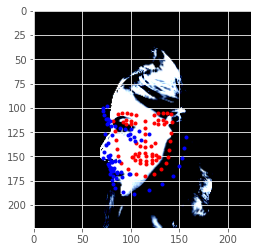

0.7282339064975973
68.0
0.7216694393577725
68.0
0.680099223804566
68.0
0.8685476946357809
68.0
0.9034068480048669
68.0
0.8536416968261513
68.0
0.7908345657093767
68.0
0.7634373236529229
68.0


KeyboardInterrupt: ignored

time: 2min 33s (started: 2022-11-21 18:07:06 +00:00)


In [41]:
#Run model on test data from 300WLPA dataset and report NME

#model.load_state_dict(torch.load('sample_data/resnet50_1000.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300WLPA_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300WLPA_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

time: 4.93 ms (started: 2022-11-20 21:19:00 +00:00)


In [ ]:
model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
checkpoint = torch.load('sample_data/my_model_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Freezing intermediate layer parameters...


FileNotFoundError: ignored

time: 867 ms (started: 2022-11-20 21:19:00 +00:00)
